In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2 as cv
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

from sklearn import preprocessing

%matplotlib inline

# Load Data

In [2]:
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
target_labels = [val for key, val in emotion_labels.items()]
targets = [key for key, val in emotion_labels.items()]

In [3]:
df = pd.read_csv('../data/fer_data.csv')
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [4]:
def load_data(df):
    image_data = []
    image_scaled = []
    
    for index, row in df.iterrows():
        image = np.fromstring(row.pixels, dtype=int, sep=' ')
        scale = image / 255.0
        image_data.append(image)
        image_scaled.append(scale)
        
    return image_data, image_scaled

In [5]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test)
test_target = list(df_test.emotion)

# PCA (original data)

In [6]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

## Find how many component is good enough

In [7]:
pca = PCA()
pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([2.88982571e-01, 1.00608235e-01, 9.39809718e-02, ...,
       5.26681905e-07, 5.20276485e-07, 5.10838653e-07])

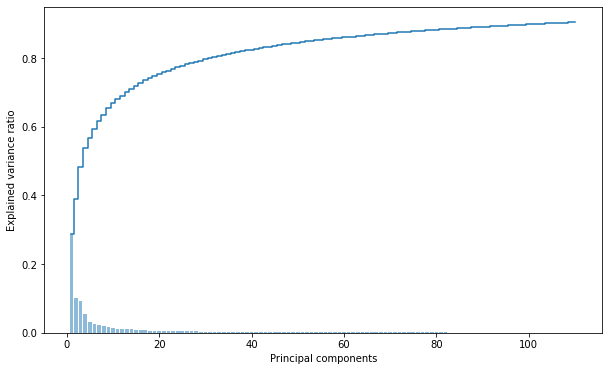

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 111), pca.explained_variance_ratio_[0:110], alpha=0.5, align='center')
plt.step(range(1, 111), np.cumsum(pca.explained_variance_ratio_[0:110]), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [9]:
cumsum = np.cumsum(pca.explained_variance_ratio_[0:500])
print(cumsum[102])
print(cumsum[103])

0.8999656120060382
0.9006065377360862


## Display EigenFace

In [10]:
pca = PCA(n_components=103, whiten=True)
pca.fit(X_train)

PCA(n_components=103, whiten=True)

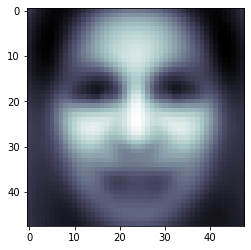

In [11]:
plt.imshow(pca.mean_.reshape((48,48)),
           cmap=plt.cm.bone)

In [12]:
print(pca.components_.shape)

(103, 2304)


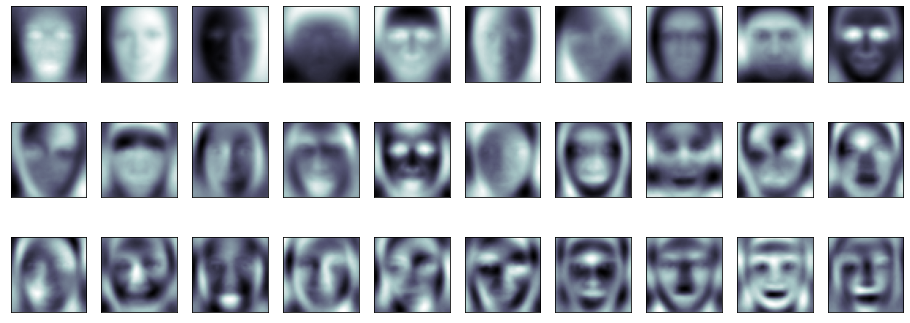

In [13]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((48,48)),
              cmap=plt.cm.bone)

In [14]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(31432, 103)
(7896, 103)


In [15]:
X_train_pca

array([[-0.45897133,  0.96209355, -0.5578826 , ..., -1.98829538,
         0.78766689, -1.18995873],
       [ 0.49198604, -1.00218016,  0.27409517, ...,  1.03459556,
        -0.3437458 ,  0.66745623],
       [-0.94195011,  1.43852495,  0.29373886, ..., -0.00327883,
         0.0723599 , -1.14690419],
       ...,
       [-1.12354735,  0.75749747,  0.34768167, ..., -0.19373565,
        -1.13971001, -0.46139888],
       [ 1.15936041,  0.56849818,  1.0274089 , ...,  0.75576035,
        -0.3864568 ,  0.33241596],
       [-0.0052239 ,  1.4921513 , -1.59121368, ..., -1.38726407,
        -1.8193752 ,  2.69956445]])

## Save PCA data

In [16]:
def combineData(usage, X, y):
    pca_data = []
    for i in range(len(X)):
        val = ' '.join(str(v) for v in X[i])
        pca_data.append([usage, y[i], val])
    return pca_data

def savePCA(file, X_train, y_train, X_test, y_test):
    train_data = combineData('train', X_train, y_train)
    test_data = combineData('test', X_test, y_test)
    data = train_data + test_data
    df = pd.DataFrame(data, columns = ['usage', 'emotion', 'pca'])
    df.to_csv(file, index=False)
    df.info()

In [17]:
savePCA('../data/pca/fer_pca.csv', X_train_pca, y_train, X_test_pca, y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39328 entries, 0 to 39327
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   usage    39328 non-null  object
 1   emotion  39328 non-null  int64 
 2   pca      39328 non-null  object
dtypes: int64(1), object(2)
memory usage: 921.9+ KB


# PCA (scaled data)

In [18]:
X_train = np.array(train_scaled)
y_train = np.array(train_target)
X_test = np.array(test_scaled)
y_test = np.array(test_target)

In [19]:
X_train

array([[0.42352941, 0.3254902 , 0.24705882, ..., 0.45490196, 0.47843137,
        0.47843137],
       [0.5372549 , 0.55686275, 0.62352941, ..., 0.74901961, 0.75294118,
        0.75294118],
       [0.43529412, 0.58039216, 0.60784314, ..., 0.22352941, 0.21960784,
        0.23529412],
       ...,
       [0.84313725, 0.43921569, 0.40784314, ..., 0.43137255, 0.39215686,
        0.40392157],
       [0.10588235, 0.07843137, 0.07843137, ..., 0.18431373, 0.19215686,
        0.21176471],
       [0.99607843, 0.99607843, 0.98039216, ..., 0.07843137, 0.09803922,
        0.19215686]])

## Find how many component is good enough

In [ ]:
pca = PCA()
pca.fit_transform(X_train)
pca.explained_variance_ratio_

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 111), pca.explained_variance_ratio_[0:110], alpha=0.5, align='center')
plt.step(range(1, 111), np.cumsum(pca.explained_variance_ratio_[0:110]), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_[0:500])
print(cumsum[102])
print(cumsum[103])

## Display EigenFace

In [ ]:
pca = PCA(n_components=103, whiten=True)
pca.fit(X_train)

In [ ]:
plt.imshow(pca.mean_.reshape((48,48)),
           cmap=plt.cm.bone)

In [ ]:
print(pca.components_.shape)

In [ ]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((48,48)),
              cmap=plt.cm.bone)

Results are same as original data values

In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

In [ ]:
X_train_pca

## Save PCA data

In [ ]:
savePCA('../data/pca/fer_pca_scaled.csv', X_train_pca, y_train, X_test_pca, y_test)

# PCA (Standardization data)

In [ ]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [ ]:
X_train = preprocessing.StandardScaler().fit_transform(X_train)
X_test = preprocessing.StandardScaler().fit_transform(X_test)

In [ ]:
X_train

## Find how many component is good enough

In [ ]:
pca = PCA()
pca.fit_transform(X_train)
pca.explained_variance_ratio_

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 121), pca.explained_variance_ratio_[0:120], alpha=0.5, align='center')
plt.step(range(1, 121), np.cumsum(pca.explained_variance_ratio_[0:120]), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_[0:500])
print(cumsum[111])
print(cumsum[112])

## Display EigenFace

In [ ]:
pca = PCA(n_components=112, whiten=True)
pca.fit(X_train)

In [ ]:
plt.imshow(pca.mean_.reshape((48,48)),
           cmap=plt.cm.bone)

In [ ]:
pca.mean_

In [ ]:
print(pca.components_.shape)

In [ ]:
pca.components_

In [ ]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((48,48)),
              cmap=plt.cm.bone)

In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

In [ ]:
X_train_pca

## Save PCA data

In [ ]:
savePCA('../data/pca/fer_pca_std.csv', X_train_pca, y_train, X_test_pca, y_test)

# PCA (Normalization data)

In [ ]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [ ]:
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [ ]:
X_train

## Find how many component is good enough

In [ ]:
pca = PCA()
pca.fit_transform(X_train)
pca.explained_variance_ratio_

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 161), pca.explained_variance_ratio_[0:160], alpha=0.5, align='center')
plt.step(range(1, 161), np.cumsum(pca.explained_variance_ratio_[0:160]), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_[0:500])
print(cumsum[156])
print(cumsum[157])

## Display EigenFace

In [ ]:
pca = PCA(n_components=157, whiten=True)
pca.fit(X_train)

In [ ]:
plt.imshow(pca.mean_.reshape((48,48)),
           cmap=plt.cm.bone)

In [ ]:
pca.mean_

In [ ]:
print(pca.components_.shape)

In [ ]:
pca.components_

In [ ]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((48,48)),
              cmap=plt.cm.bone)

In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

In [ ]:
X_train_pca

## Save PCA data

In [ ]:
savePCA('../data/pca/fer_pca_norm.csv', X_train_pca, y_train, X_test_pca, y_test)

# PCA then Inverse data

In [ ]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [ ]:
pca = PCA(n_components=103, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_train_inverse = pca.inverse_transform(X_train_pca)
X_train_inverse

In [ ]:
X_train

In [ ]:
X_test_pca = pca.fit_transform(X_test)
X_test_inverse = pca.inverse_transform(X_test_pca)
X_test_inverse

In [ ]:
X_test

In [ ]:
X_train_pca.shape

## Display Inverse PCA images

In [ ]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train_inverse[i].reshape((48,48)),
              cmap=plt.cm.bone)

## Save data

In [ ]:
savePCA('../data/pca/fer_pca_inverse.csv', X_train_inverse, y_train, X_test_inverse, y_test)